#Introducción
---
TFM: Aplicación de ciencia de datos en el sector de producción animal para la predicción y explicación de óptimos en ganado porcino.

*Titulo*: **KNeighborsRegressor**

*Autor*: **Jose Eduardo Cámara Gómez**

---

## Importar paquetes

In [1]:
# Importación de paquetes
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.neighbors import KNeighborsRegressor

sns.set(style="darkgrid")

In [2]:
from google.colab import files
# Cargamos el fichero del dataset gmd_02.csv
uploaded = files.upload()
# Leemos el fichero csv con los datos
df = pd.read_csv('gmd_02.csv', sep=';')
# Revisar la raza si se agrupan las razas con menos ocurrencias
agrupar_razas = {93 : 93, 85 : 93, 90 : 93, 95 : 93, 94 : 93, 82 : 93, 80 : 80, 96 : 80, 88 : 88, 0 : 0, 23 : 0,
                 84 : 0, 66 : 0, 18 : 0, 68 : 88, 7 : 7, 89 : 7, 65 : 7, 15 : 15, 97 : 7, 69 : 69, 81 : 81}
df.replace({'ct_raza' : agrupar_razas}, inplace=True)
df["bajas"] = df["NumBajas"] / (df["NumAnimales"] * df["DiasMedios"])
# Convertimos los tipos
df["ct_integra"] = df["ct_integra"].astype("category")
#df["ct_tipo"] = df["ct_tipo"].astype("category")
df["ct_raza"] = df["ct_raza"].astype("category")
df["ct_fase"] = df["ct_fase"].astype("category")
df['EntradaInicial']= pd.to_datetime(df['EntradaInicial'])
df['EntradaFinal']= pd.to_datetime(df['EntradaFinal'])
df["na_rega"] = df["na_rega"].astype("category")
df["NumBajas"] = df["NumBajas"].astype("int64")
df["gr_codpos"] = df["gr_codpos"].astype("category")
df["gr_poblacion"] = df["gr_poblacion"].astype("category")
df["na_nombre2"] = df["na_nombre2"].astype("category")

# Funcion para convertir en One Hot Encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
# Cargamos las variables objetivo y las usadas (15 variables seleccionadas, una de ellas categórica con 8 valores).
y = df['GMD']
x0 = df[['ct_integra','ct_tipo', 'ct_raza', 'IncPeso', 'NumAnimales', 'na_rega', 
         'PesoEntMedio', 'PesoRecMedio', 'bajas', 'GPS_Longitud', 'GPS_Latitud', 
         'semanaEntrada', 'añoEntrada', 'PorcHembras', 'PiensoCerdaDia']]
features_to_encode = ['ct_raza']   # , 'na_rega']
x1 = x0.copy()
x1.drop(['ct_integra','na_rega'], inplace=True, axis=1)
for feature in features_to_encode:
    x1 = encode_and_bind(x1, feature)

Saving gmd_02.csv to gmd_02.csv


In [3]:
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state = 123)
## Vemos de escalar las variables para que no se vean influenciadas por los outliers.
scaler = RobustScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Lanzar modelo por defecto

In [5]:
# Lanzamos el modelo con los parámetros por defecto
modelo = KNeighborsRegressor (
            n_neighbors=5, 
            weights='uniform', 
            algorithm='auto', 
            leaf_size=30, 
            p=2, 
            metric='minkowski', 
            metric_params=None, 
            n_jobs=None
         )
modelo.fit(X_train_s, y_train)

KNeighborsRegressor()

Score R2: 0.7459138720387797


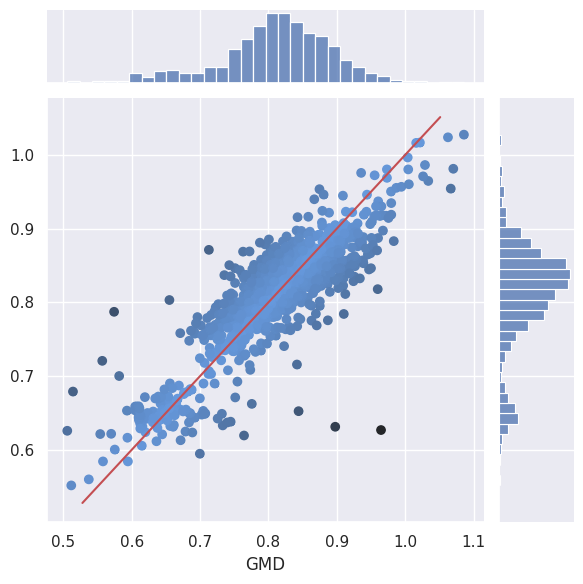

In [6]:
# Función para Graficar diferencias entre valor predicho y real en datos de test del modelo pasado
def graficoDiferencias(modelo, X_test_s, y_test):
    y_pred = modelo.predict(X_test_s)
    diferencia = abs(y_pred - y_test)
    g = sns.jointplot(x=y_test, y=y_pred)
    # Draw a line of x=y
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, '-r')
    g.ax_joint.scatter(x=y_test, y=y_pred, c=diferencia.values, cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True))
    plt.show()

# Graficar las diferencias
print('Score R2:',modelo.score(X_test_s, y_test))
graficoDiferencias(modelo, X_test_s, y_test)

Vemos como se comporta con menos variables, por ejemplo vamos a estudiar que pasa para las 7 más relevantes según RandomForest.

In [10]:
x2 = x1[['PesoRecMedio','ct_raza_69','ct_tipo','PesoEntMedio','IncPeso','PorcHembras','semanaEntrada']].copy()
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size = 0.2, random_state = 123)
## Vemos de escalar las variables para que no se vean influenciadas por los outliers.
scaler = RobustScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

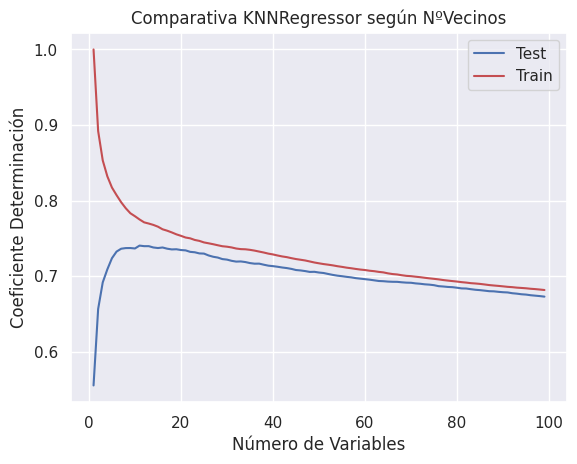

In [29]:
# Lanzamos el modelo con los parámetros por defecto, para los 100 primeros valores de vecinos más cercanos
from sklearn.metrics import r2_score
r2_train = list()
r2_test = list()
for i in range(1,100):
  modelo = KNeighborsRegressor (
            n_neighbors=i, 
            weights='uniform', 
            algorithm='auto', 
            leaf_size=30, 
            p=2, 
            metric='minkowski', 
            metric_params=None, 
            n_jobs=None
         )
  modelo.fit(X_train_s, y_train)
  # Graficar las diferencias
  r2_train.append(r2_score(y_train, modelo.predict(X_train_s)))
  r2_test.append(r2_score(y_test, modelo.predict(X_test_s)))
  # print('Score R2 para n_neighbors=',i, 'Train:', r2_score(y_train, modelo.predict(X_train_s)),'\t','Test:', r2_score(y_test, modelo.predict(X_test_s)))
sns.lineplot(x=range(1,100), y=r2_test, label="Test")
sns.lineplot(x=range(1,100), y=r2_train, c='r', label="Train")
plt.legend()
plt.xlabel("Número de Variables")
plt.ylabel("Coeficiente Determinación")
plt.title("Comparativa KNNRegressor según NºVecinos")
plt.show()

Para esas variables el valor más alto es el de n=16, que obtiene un R2=0.7050. Veo ahora como se comporta si modificamos el núumero de variables desde 1 a 21 para los datos y orden que tenemos según RandomForest.

Score R2 para variables= 1 Train: 0.6705166094575745 	 Test: 0.6381669196044853
Score R2 para variables= 2 Train: 0.6828041807738229 	 Test: 0.6553354693811115
Score R2 para variables= 3 Train: 0.690438873499253 	 Test: 0.6638840821849186
Score R2 para variables= 4 Train: 0.6889679181955092 	 Test: 0.6503348539634992
Score R2 para variables= 5 Train: 0.683807580504175 	 Test: 0.6511477204934475
Score R2 para variables= 6 Train: 0.7142649850034557 	 Test: 0.6914857532835079
Score R2 para variables= 7 Train: 0.7305353480639281 	 Test: 0.704989781208365
Score R2 para variables= 8 Train: 0.727049674919438 	 Test: 0.6831335621543003
Score R2 para variables= 9 Train: 0.7536903649786754 	 Test: 0.7217233354036477
Score R2 para variables= 10 Train: 0.7621505380817271 	 Test: 0.7380769691403543


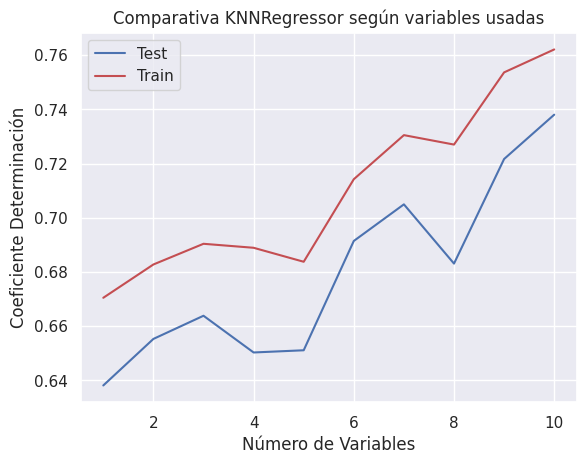

In [28]:
top10_variables = ['PesoRecMedio','ct_raza_69','ct_tipo','PesoEntMedio','IncPeso','PorcHembras','semanaEntrada','NumAnimales','ct_raza_93','bajas']
r2_train_v = list()
r2_test_v = list()
for n_var in range(1,11):
  x3 = x1[top10_variables[:n_var]].copy()
  X_train, X_test, y_train, y_test = train_test_split(x3, y, test_size = 0.2, random_state = 123)
  ## Vemos de escalar las variables para que no se vean influenciadas por los outliers.
  scaler = RobustScaler()
  scaler.fit(X_train)
  X_train_s = scaler.transform(X_train)
  X_test_s = scaler.transform(X_test)
  # Entremamos el modelo con esas variables
  modelo = KNeighborsRegressor (n_neighbors=16, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
  modelo.fit(X_train_s, y_train)
  r2_test_v.append(r2_score(y_test, modelo.predict(X_test_s)))
  r2_train_v.append(r2_score(y_train, modelo.predict(X_train_s)))
  print('Score R2 para variables=',n_var, 'Train:', r2_score(y_train, modelo.predict(X_train_s)),'\t','Test:', r2_score(y_test, modelo.predict(X_test_s)))
# Graficamos los datos
sns.lineplot(x=range(1,11), y=r2_test_v, label="Test")
sns.lineplot(x=range(1,11), y=r2_train_v, c='r', label="Train")
plt.legend()
plt.xlabel("Número de Variables")
plt.ylabel("Coeficiente Determinación")
plt.title("Comparativa KNNRegressor según variables usadas")
plt.show()
